# **Problema 3 - Aprendizaje Automático II**
# *Integrantes*:
* ### Demarré, Lucas
* ### Donnarumma, César
* ### Longo, Bruno

---

# **Tabla de contenidos**

1.   [**Librerías**](#)
2.   [**Descargamos y descomprimimos el Dataset**](#)
3.   [**Establecemos la GPU por defecto en caso de estar disponible**](#)
4.   [**Cargamos los Datasets**](#)
5.   [**Visualizamos algunas imágenes**](#)
6.   [**Información de los Datasets**](#)
        1.   [*Clases*](#)
        2.   [*Dataset de entrenamiento*](#)
        3.   [*Dataset de validación*](#)
        4.   [*Dataset de prueba*](#)
        5.   [*Observaciones*](#)
7.   [**Redes Neuronales Densas**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Prueba 3*](#)
        4.   [*Observaciones*](#)
8.   [**Modelos con capas densas y convolucionales**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Prueba 3*](#)
        4.   [*Observaciones*](#)
9.   [**Modelos con bloques residuales identidad**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Observaciones*](#)
10.   [**Modelo que usa como backbone una arquitectura de TensorFlow**](#)
        1.   [*EfficientNet*](#)
        2.   [*ResNet50*](#)
        3.   [*Observaciones*](#)

## 1. **Librerías**

In [30]:
import gdown
import optuna
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Rescaling, Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Add

## 2. **Descargamos y descomprimimos el Dataset**

In [4]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref: zip_ref.extractall('./TP1-3')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=a9a817d3-9540-4fc8-bd28-12f8bd8efee0
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:08<00:00, 43.5MB/s]


## 3. **Establecemos la GPU por defecto en caso de estar disponible**

In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 4. **Cargamos los Datasets**

In [6]:
# Definimos las rutas a los datasets
train_dir = 'TP1-3/seg_train/seg_train'
test_dir = 'TP1-3/seg_test/seg_test'

# Definimos el tamaño de lote y las dimensiones de las imágenes
batch_size = 64
img_height = 64
img_width = 64

# Utilizamos 'ImageDataGenerator' para cargar las imágenes
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Agregamos 'validation_split=0.2' para separar el 20% de los datos para validación
test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

# Cargamos las imágenes de entrenamiento, validación, prueba y predicción
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 5. **Visualizamos algunas imágenes**

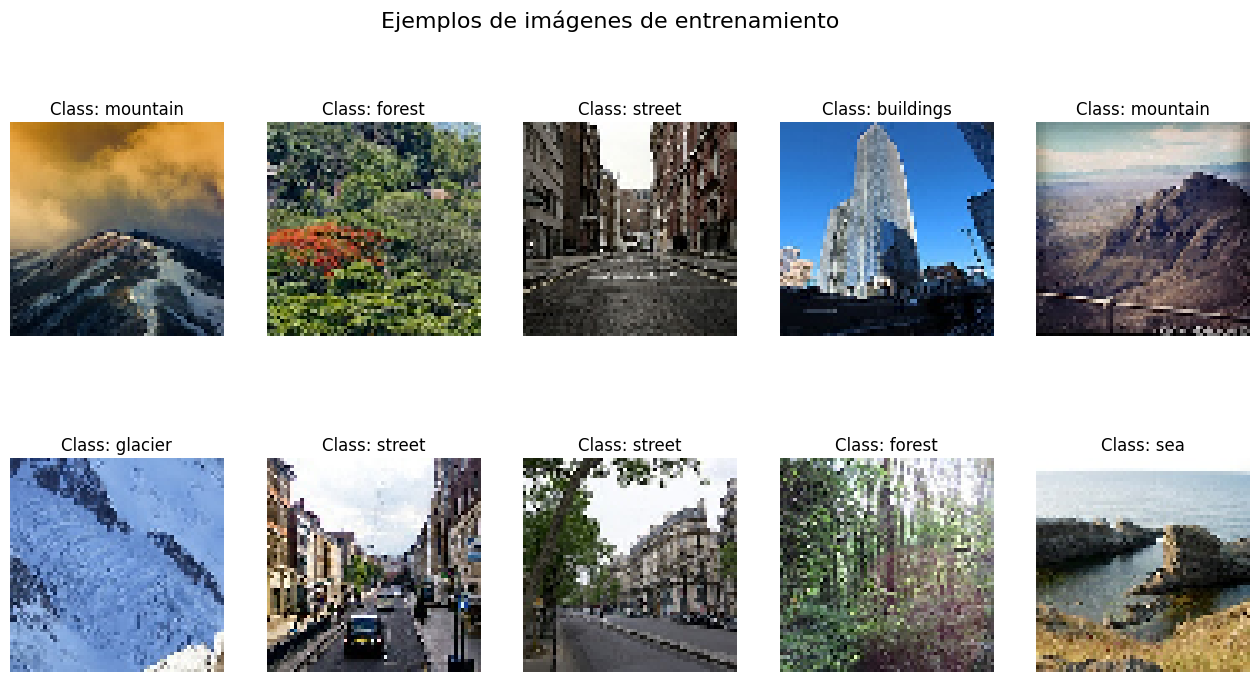

In [7]:
# Obtenemos el diccionario de mapeo de clases
class_mapping = train_data.class_indices

# Invertimos el diccionario para obtener un mapeo de nombres de clases a números
class_mapping = {v: k for k, v in class_mapping.items()}

# Función para visualizar las imágenes
def visualizar_ejemplos(dataset, nombre_dataset):
    # Obtenemos un lote de imágenes y etiquetas
    imagenes, etiquetas = dataset.next()

    # Definimos el tamaño de la cuadrícula para visualización
    num_filas, num_columnas = 2, 5
    num_imagenes = num_filas * num_columnas

    # Creamos una figura para visualizar las imágenes
    plt.figure(figsize=(16, 8))
    plt.suptitle('Ejemplos de imágenes de ' + nombre_dataset, fontsize=16)

    # Visualizamos las imágenes
    for i in range(num_imagenes):
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(imagenes[i])
        clase_num = etiquetas[i].argmax()
        plt.title('Class: ' + class_mapping[clase_num])
        plt.axis('off')
    plt.show()

# Visualizar ejemplos del conjunto de entrenamiento
visualizar_ejemplos(train_data, 'entrenamiento')

## 6. **Información de los Datasets**

### 6.1. *Clases*

In [11]:
print('Clases:\n')
for key, value in class_mapping.items():
    print(f"{key}: {value}")

Clases:

0: buildings
1: forest
2: glacier
3: mountain
4: sea
5: street


### 6.2. Dataset de entrenamiento

In [12]:
valores_unicos, conteos = np.unique(train_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 11230

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0      1753     15.61
1      1      1817     16.18
2      4      1820     16.21
3      5      1906     16.97
4      2      1924     17.13
5      3      2010     17.90


### 6.3. Dataset de validación

In [13]:
valores_unicos, conteos = np.unique(val_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 2804

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0       438     15.62
1      1       454     16.19
2      4       454     16.19
3      5       476     16.98
4      2       480     17.12
5      3       502     17.90


### 6.4. Dataset de prueba

In [14]:
valores_unicos, conteos = np.unique(test_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 3000

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0       437     14.57
1      1       474     15.80
2      5       501     16.70
3      4       510     17.00
4      3       525     17.50
5      2       553     18.43


### 6.5. **Observaciones**

Parece ser que el Dataset de entrenamiento esta ligeramente desbalanceado

## 7. **Modelos con únicamente capas densas**

### 7.1. *Prueba 1*

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 12288)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12288)             0         
                                                                 
 dense_14 (Dense)            (None, 793)               9745177   
                                                                 
 dropout_7 (Dropout)         (None, 793)               0         
                                                                 
 dense_15 (Dense)            (None, 6)                 4764      
                                                                 
Total params: 9749941 (37.19 MB)
Trainable params: 9749941 (37.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
17

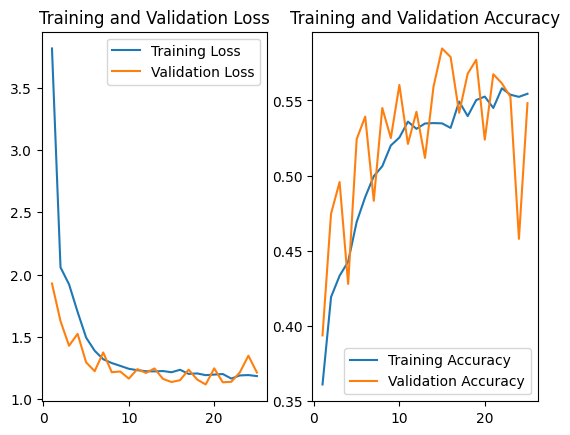


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  1.022613  0.610062
Test   1.239645  0.535667
---------------------------------------------------------

47/47 [==============================] - 2s 47ms/step


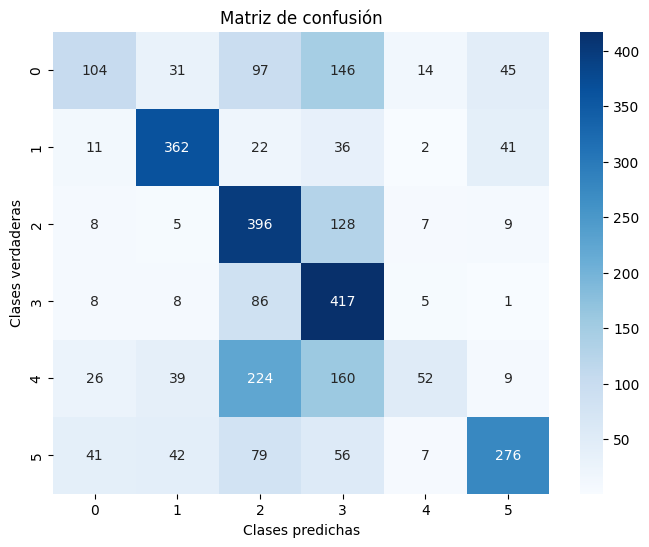


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.53      0.24      0.33       437
           1       0.74      0.76      0.75       474
           2       0.44      0.72      0.54       553
           3       0.44      0.79      0.57       525
           4       0.60      0.10      0.17       510
           5       0.72      0.55      0.63       501

    accuracy                           0.54      3000
   macro avg       0.58      0.53      0.50      3000
weighted avg       0.57      0.54      0.50      3000



In [26]:
# Modelo
model = Sequential()
model.add(Flatten(input_shape=(64,64,3)))
model.add(Dropout(0.591121618030709))
model.add(Dense(units=793, activation='leaky_relu'))
model.add(Dropout(0.28907592045886715))
model.add(Dense(units=6, activation='softmax'))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 7.2. *Prueba 2*

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 12288)             0         
                                                                 
 dense_41 (Dense)            (None, 128)               1572992   
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                                 
 dense_44 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1,585,798
Trainable params: 1,585,798
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
176/176 [======================

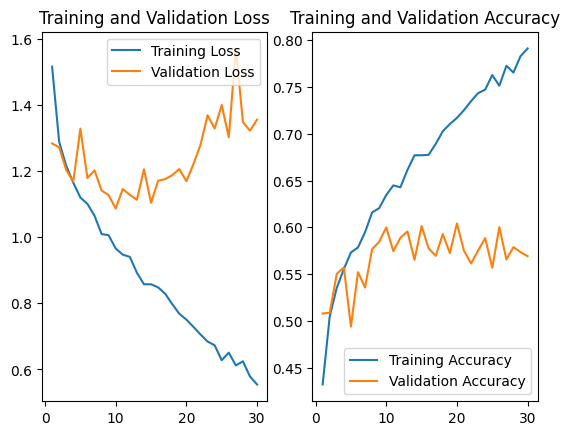


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.535854  0.795102
Test   1.365279  0.560333
---------------------------------------------------------

47/47 [==============================] - 1s 28ms/step


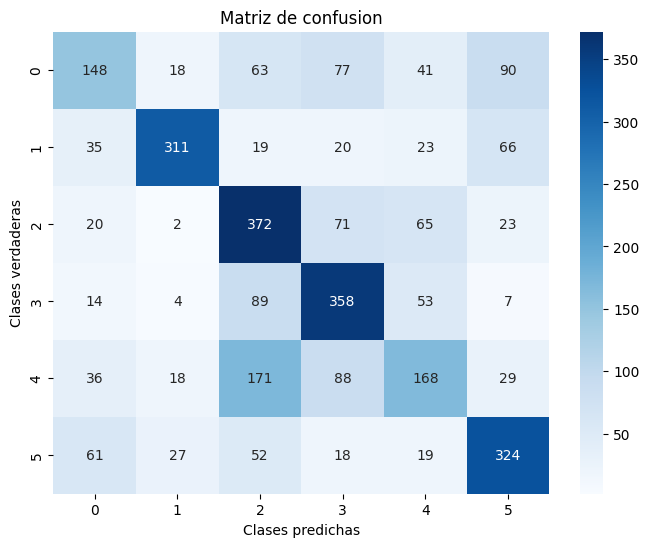


Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.47      0.34      0.39       437
           1       0.82      0.66      0.73       474
           2       0.49      0.67      0.56       553
           3       0.57      0.68      0.62       525
           4       0.46      0.33      0.38       510
           5       0.60      0.65      0.62       501

    accuracy                           0.56      3000
   macro avg       0.57      0.55      0.55      3000
weighted avg       0.56      0.56      0.55      3000



In [ ]:
# Modelo
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 7.3. *Prueba 3*

Epoch 1/200
176/176 [==============================] - 7s 37ms/step - loss: 1.5232 - accuracy: 0.4206 - val_loss: 1.3200 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 6s 36ms/step - loss: 1.3015 - accuracy: 0.4988 - val_loss: 1.2501 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 6s 35ms/step - loss: 1.2485 - accuracy: 0.5221 - val_loss: 1.2328 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 6s 34ms/step - loss: 1.1752 - accuracy: 0.5562 - val_loss: 1.2319 - val_accuracy: 0.5292 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 6s 36ms/step - loss: 1.1280 - accuracy: 0.5733 - val_loss: 1.3013 - val_accuracy: 0.5225 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 6s 35ms/step - loss: 1.0641 - accuracy: 0.6012 - val_loss: 1.1221 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 7/200
176/176 [==============================] - 6s 

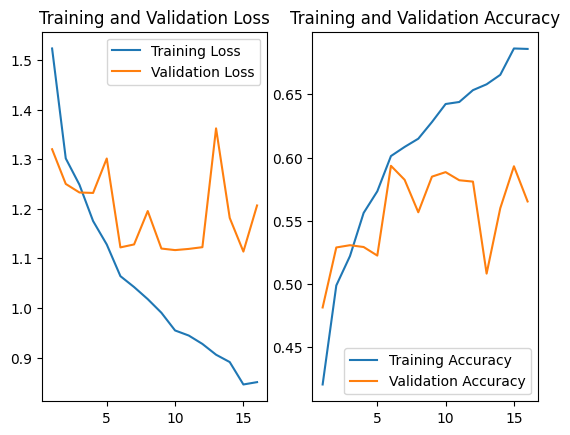


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.847077  0.677026
Test   1.249070  0.554333
---------------------------------------------------------

47/47 [==============================] - 1s 28ms/step


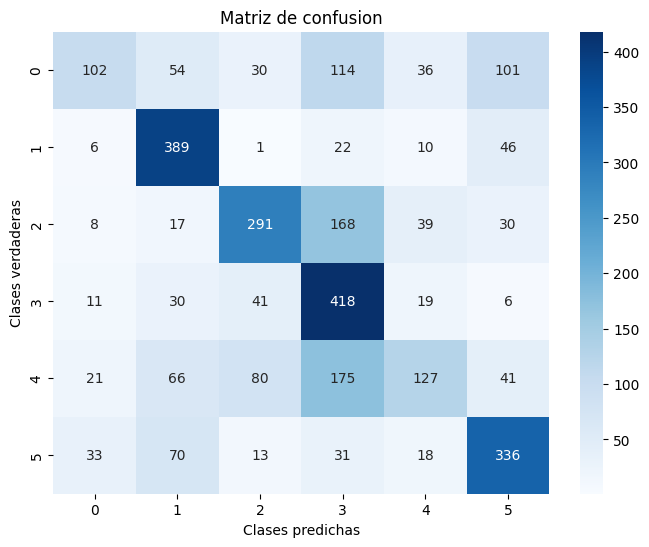


Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.56      0.23      0.33       437
           1       0.62      0.82      0.71       474
           2       0.64      0.53      0.58       553
           3       0.45      0.80      0.58       525
           4       0.51      0.25      0.33       510
           5       0.60      0.67      0.63       501

    accuracy                           0.55      3000
   macro avg       0.56      0.55      0.53      3000
weighted avg       0.56      0.55      0.53      3000



In [ ]:
# Definimos el modelo con capas densas únicamente
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 7.4. *Observaciones*

Lo que podemos ver en estas tres pruebas es que las métricas son poco favorables, la de prueba con mayor métrica fue la **Prueba 1** y es dado por su complejidad, como siempre hacemos pruebas más y menos complejas para ver las diferencias entre ellas. En este caso, por el alto tiempo de ejecución de todas las pruebas y la precaridad de sus métricas, concluímos que, para clasificar estas imágenes, se usen modelos más complejos con capas convolucionales por lo menos.

## 8. **Modelos con capas densas y convolucionales**

### 8.1. *Prueba 1*

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_2 (Rand  (None, 64, 64, 3)         0         
 omTranslation)                                                  
                                                                 
 random_contrast_2 (RandomC  (None, 64, 64, 3)         0         
 ontrast)                                                        
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 16)        448 

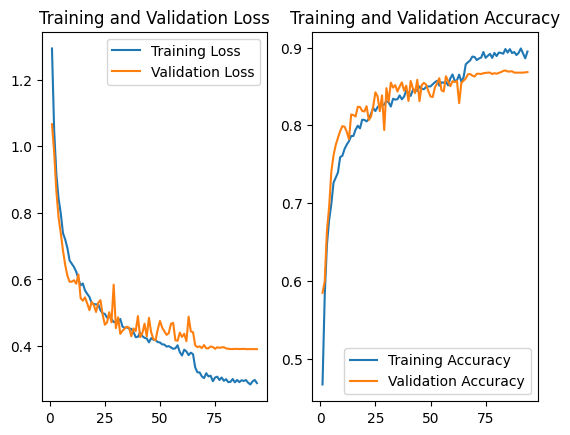


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.250934  0.912556
Test   0.421517  0.857000
---------------------------------------------------------

47/47 [==============================] - 3s 65ms/step


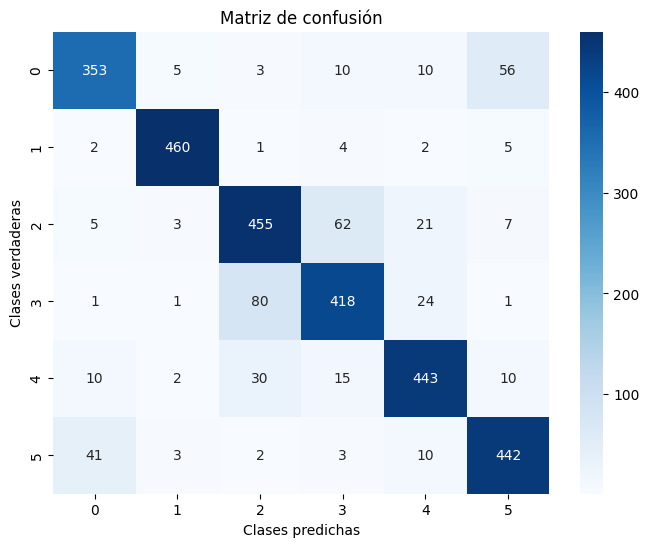


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       437
           1       0.97      0.97      0.97       474
           2       0.80      0.82      0.81       553
           3       0.82      0.80      0.81       525
           4       0.87      0.87      0.87       510
           5       0.85      0.88      0.86       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [18]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Data Augmentation
    x = RandomFlip("horizontal")(i)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Capas convolucionales
    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Capa de salida
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)

    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((64, 64, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 8.2. *Prueba 2*

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_3 (Rand  (None, 64, 64, 3)         0         
 omTranslation)                                                  
                                                                 
 random_contrast_3 (RandomC  (None, 64, 64, 3)         0         
 ontrast)                                                  

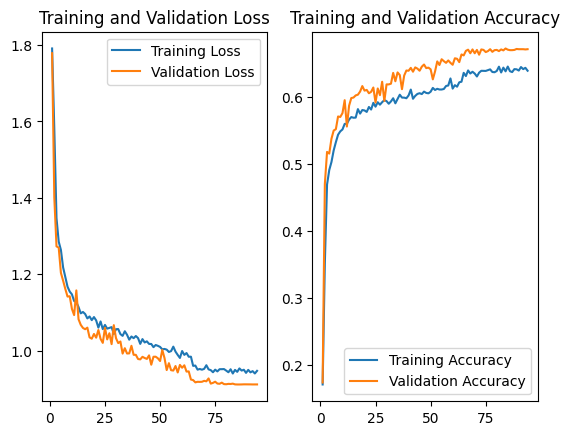


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.891209  0.665272
Test   0.914850  0.653667
---------------------------------------------------------

47/47 [==============================] - 2s 42ms/step


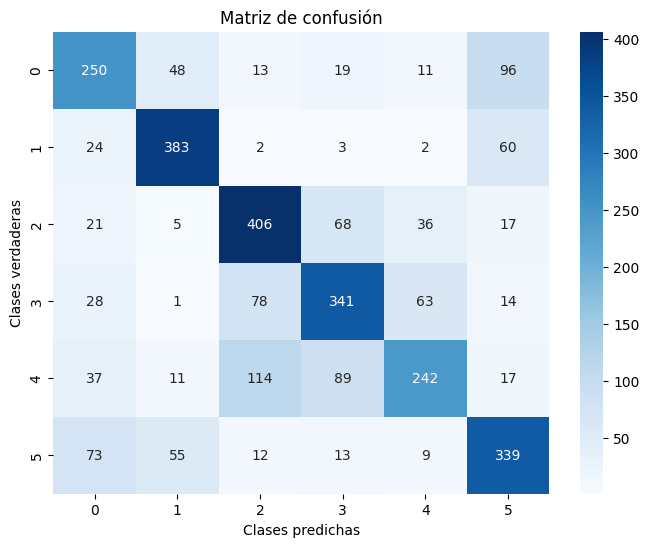


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       437
           1       0.76      0.81      0.78       474
           2       0.65      0.73      0.69       553
           3       0.64      0.65      0.64       525
           4       0.67      0.47      0.55       510
           5       0.62      0.68      0.65       501

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.65      3000
weighted avg       0.65      0.65      0.65      3000



In [19]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = RandomFlip('horizontal')(x)
    x = RandomFlip('vertical')(x)
    x = RandomTranslation(0.1, 0.1, fill_mode='reflect')(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation('relu')(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation('softmax')(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((64, 64, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 8.3. *Prueba 3*

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 128)       7385

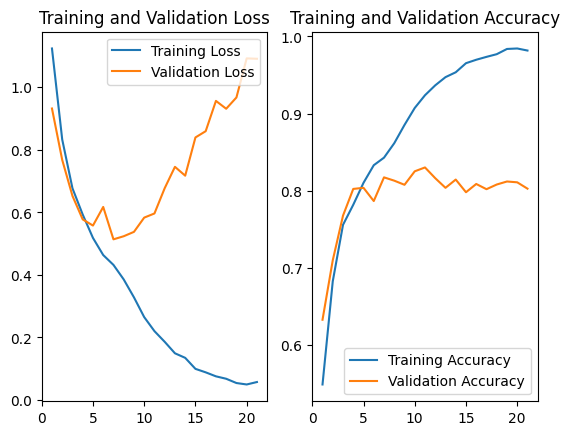


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.050635  0.984239
Test   1.071686  0.797000
---------------------------------------------------------

47/47 [==============================] - 2s 44ms/step


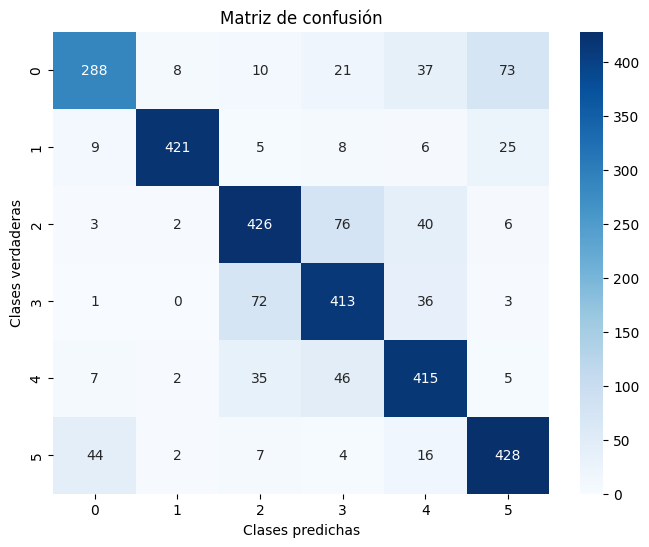


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       437
           1       0.97      0.89      0.93       474
           2       0.77      0.77      0.77       553
           3       0.73      0.79      0.76       525
           4       0.75      0.81      0.78       510
           5       0.79      0.85      0.82       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [20]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Conv2D(32, (3, 3), activation='relu')(i)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(output_labels, activation='softmax')(x)

    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((64, 64, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 8.4. *Observaciones*

Como ya venimos haciendo, hicimos tres pruebas utilizando distintos modelos con distintos niveles de complejidad. La **Prueba 1** fue la que logro las mejores métricas mientras que la **Prueba 3** fue el que terminó en el menor tiempo pero con un alto overfitting. La **Prueba 2** tardo casi lo mismo que la **Prueba 1** con métricas no tan favorables.

En este caso, la mejor prueba sea la **Prueba 1** por su bajo overfitting y su muy favorables métricas.

## 9. **Modelos con bloques residuales identidad**

### 9.1. *Prueba 1*

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 random_flip_10 (RandomFlip  (None, 64, 64, 3)            0         ['input_7[0][0]']             
 )                                                                                                
                                                                                                  
 random_flip_11 (RandomFlip  (None, 64, 64, 3)            0         ['random_flip_10[0][0]']      
 )                                                                                                
                                                                                            

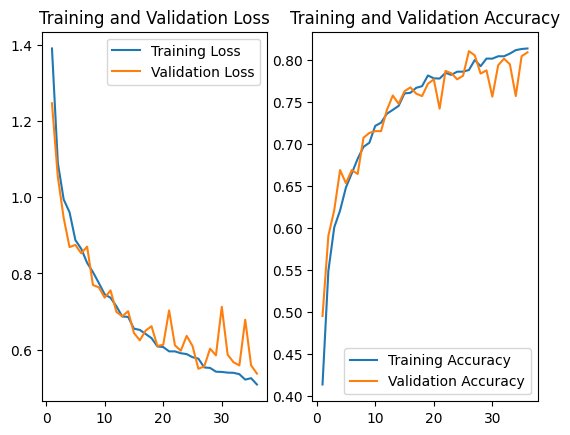


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.461427  0.826981
Test   0.514748  0.808667
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


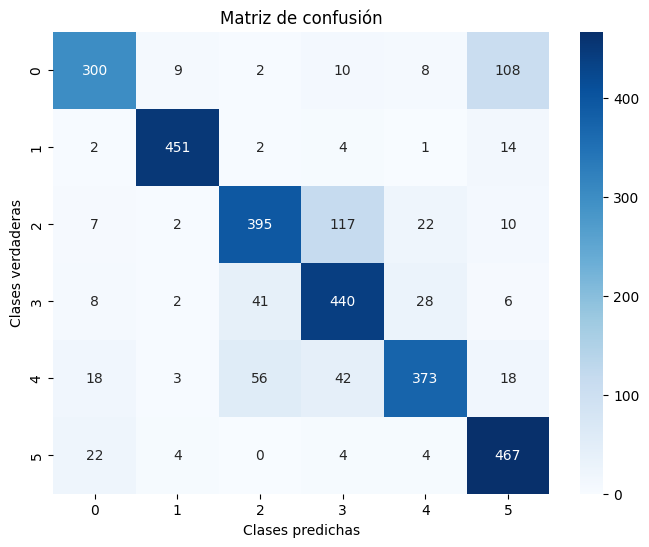


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       437
           1       0.96      0.95      0.95       474
           2       0.80      0.71      0.75       553
           3       0.71      0.84      0.77       525
           4       0.86      0.73      0.79       510
           5       0.75      0.93      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000



In [22]:
def residual_block_identity(x, filters):
    shortcut = x

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), padding='same')(shortcut)

    x = Add()([shortcut, x])

    output = Activation('relu')(x)
    return output

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = RandomFlip('horizontal')(inputs)
    x = RandomFlip('vertical')(x)
    x = RandomTranslation(0.1, 0.1, fill_mode='reflect')(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)

    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)

    x = Conv2D(32, (3, 3), activation='relu')(x)

    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Modelo
model = build_model((64, 64, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 9.2. *Prueba 2*

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 random_flip_10 (RandomFlip  (None, 64, 64, 3)            0         ['input_7[0][0]']             
 )                                                                                                
                                                                                                  
 random_flip_11 (RandomFlip  (None, 64, 64, 3)            0         ['random_flip_10[0][0]']      
 )                                                                                                
                                                                                            

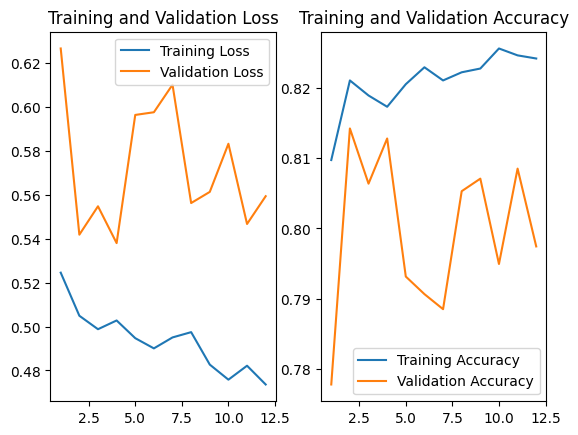


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.454129  0.832324
Test   0.536287  0.802667
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


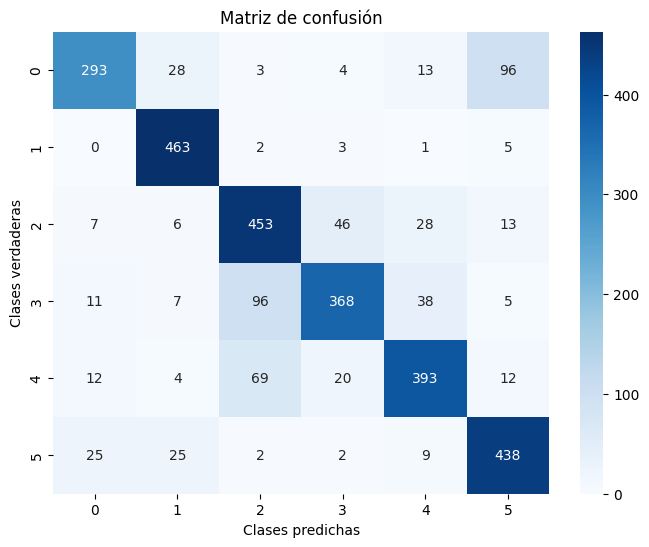


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75       437
           1       0.87      0.98      0.92       474
           2       0.72      0.82      0.77       553
           3       0.83      0.70      0.76       525
           4       0.82      0.77      0.79       510
           5       0.77      0.87      0.82       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



In [23]:
def residual_block_identity(x, filters):
    x_skip = x

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Modelo
model_residual_block = build_model(input_shape=(64, 64, 3), num_classes=6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 9.3. *Observaciones*

En este caso tenemos dos pruebas solamente. Ambas con prácticamente las mismas métricas en cuanto a rendimiento, pero la **Prueba 2** esta mucho más overfitteada que la **Prueba 1**, por lo que, en este caso, lo más favorable sería eligir la **Prueba 1** por su poco overfitting y sus buenas métricas.

## 10. **Modelo que usa como backbone una arquitectura de TensorFlow**

### 10.1. *EfficientNet*

16705208/16705208 [==============================] - 0s 0us/step
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_13 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

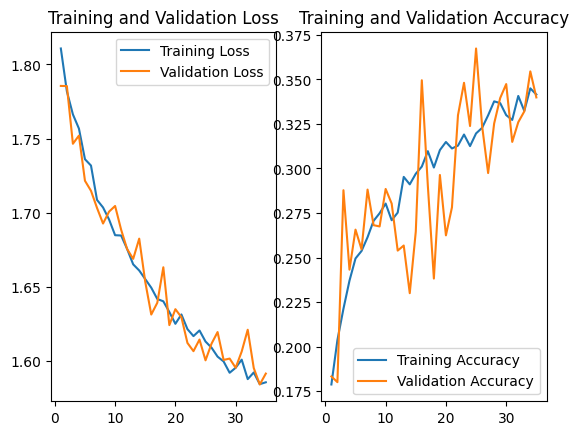


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  1.586333  0.355476
Test   1.589469  0.347000
---------------------------------------------------------

47/47 [==============================] - 4s 49ms/step


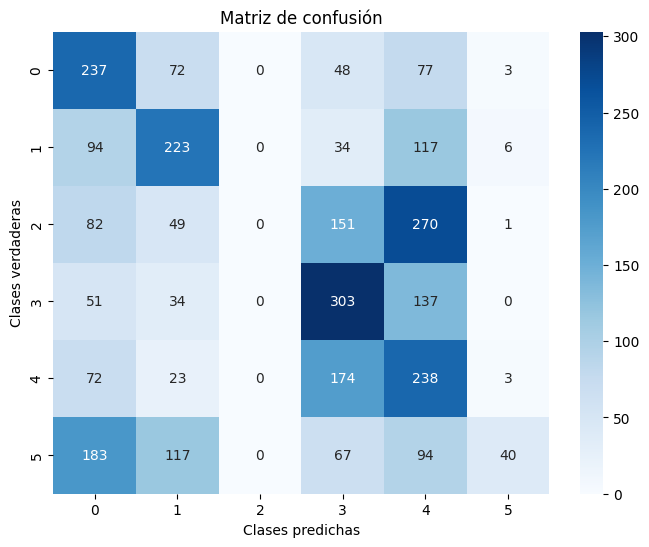


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.33      0.54      0.41       437
           1       0.43      0.47      0.45       474
           2       0.00      0.00      0.00       553
           3       0.39      0.58      0.47       525
           4       0.26      0.47      0.33       510
           5       0.75      0.08      0.14       501

    accuracy                           0.35      3000
   macro avg       0.36      0.36      0.30      3000
weighted avg       0.35      0.35      0.29      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Función para armar el modelo
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

# Creación
model = build_model((64, 64, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 10.2. *ResNet50*

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_35[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

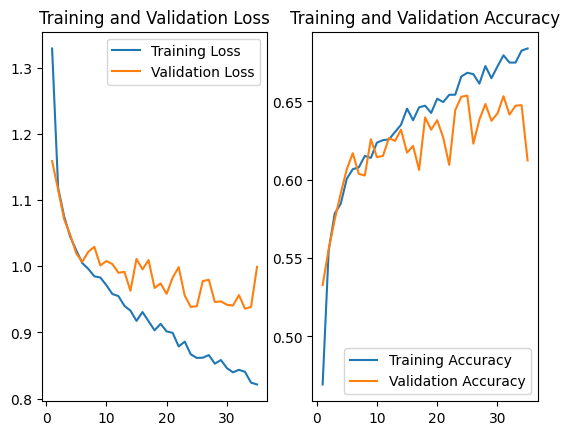


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.854190  0.662422
Test   1.023346  0.599333
---------------------------------------------------------

47/47 [==============================] - 3s 47ms/step


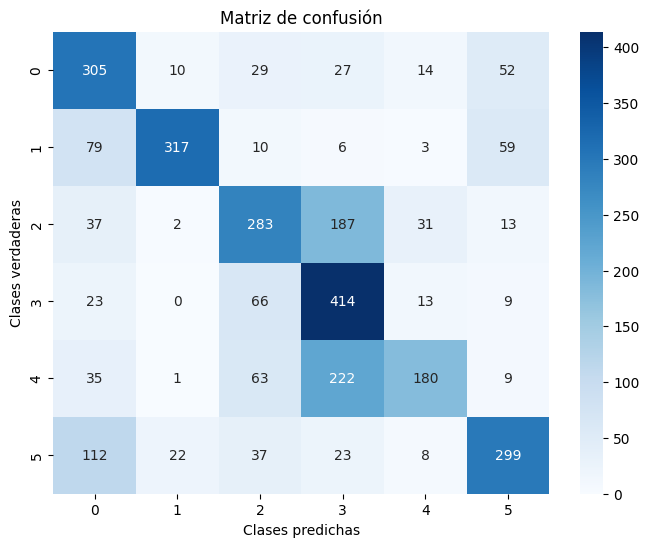


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.70      0.59       437
           1       0.90      0.67      0.77       474
           2       0.58      0.51      0.54       553
           3       0.47      0.79      0.59       525
           4       0.72      0.35      0.47       510
           5       0.68      0.60      0.63       501

    accuracy                           0.60      3000
   macro avg       0.64      0.60      0.60      3000
weighted avg       0.64      0.60      0.60      3000



In [41]:
# Cargamos el modelo ResNet50 pre-entrenado sin incluir las capas densas superiores
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congelamos las capas convolucionales base
base_model.trainable = False

# Añadimos capas adicionales personalizadas para la clasificación
x = GlobalMaxPooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

# Construimos el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

### 10.3. *Observaciones*

En este caso también tenemos solo dos pruebas, una hecha con **EfficientNet** y otra hecha con **ResNet50**. La prueba hecha con **EfficientNet** tuvo resultados muy malos, peores que los que dieron los modelos que solo utilizaban capas densas.

Por el otro lado, **ResNet50**, tuvo mejores métricas superando a los modelos de capas densas pero no a los que tenian capas convolucionales y bloques residuales identidad.

Por lo tanto, lo mejor, en este caso, para este modelo de clasificación sería utilizar algunos de los modelos que tengan capas convolucionales y densas o los que, además de eso, tienen bloques residuales identidad.